In [ ]:
#install graphviz
!apt install -y graphviz
!pip install graphviz

# KD-Tree

In [146]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [165]:
class BoundedQueue:
    def __init__(self, max_size):
        self.items = []
        self.size = 0
        self.max_size = max_size
    
    def add(self, node, dist):
        heapq.heappush(self.items, [dist, node])
        self.size += 1
        
        if self.size > self.max_size:
            print("passed max size, deleted last")
            heapq.heappop(self.items)
            self.size -=1

        print([t[0] for t in self.items])

    def is_full(self):
        return self.size == self.max_size

    def max_dist(self):
        return self.items[-1][0]

class Node:
    def __init__(self, point, k = 0, info = None):
        self.point = np.array(point)
        self.info = info
        self.k = k
        self.left = None
        self.right = None

class KDTree:
    def __init__(self, dim):
        self.dim = dim
        self.root = None
        self.plot = Digraph(node_attr={'shape': 'plaintext'})

    def update_plot(self, curNode = -1, name = ""):
        #If this is the first call of intersetion, start at the root
        if curNode == -1:
            name = "r"
            self.plot = Digraph(node_attr={'shape': 'plaintext'})
            curNode = self.root
        
        if curNode != None:
            self.plot.node(name, str(curNode.point))
            if len(name) > 1:
                self.plot.edge(name[:-1], name)
            self.update_plot(curNode.left, name + "l")
            self.update_plot(curNode.right, name + "r")
        
    def insert(self, point, info = {}, curNode = -1):
        #It the tree is empty, create the root node
        if self.root == None:
            self.root = Node(point, k = 0, info = info)
            return

        #If this is the first call of intersetion, start at the root
        if curNode == -1:
            curNode = self.root
        
        k = curNode.k
        #New point is on left subtree
        if point[k] < curNode.point[k]:
            #if child exists, call recursive
            if curNode.left != None:
                self.insert(point, info, curNode.left)
            #if child don't exists, create child
            else:
                curNode.left = Node(point, k = (k + 1)%self.dim, info = info)
        #New point is on right subtree
        else:
            #if child exists, call recursive
            if curNode.right != None:
                self.insert(point, info, curNode.right)
            #if child don't exists, create child
            else:
                curNode.right = Node(point, k = (k + 1)%self.dim, info = info)

    def k_neighbors(self, point, k):
        candidates = BoundedQueue(k)
        curNode = self.root
        self.recursive_search(point, curNode, candidates)
        result = candidates.items.copy()
        result = [(1/dist, node) for dist, node in result]
        return candidates.items

    def recursive_search(self, point, curNode, candidates):
        #End of path
        if curNode == None:
            return
        
        #Compute distance
        dist = np.square(point - curNode.point).sum()
        #Add to BPQ
        candidates.add(curNode, 1/dist)

        k = curNode.k
        search_left = False
        if point[k] < curNode.point[k]:
            search_left = True
            self.recursive_search(point, curNode.left, candidates)
        else:
            self.recursive_search(point, curNode.right, candidates)

        if (~(candidates.is_full()) | (abs(point[k] - curNode.point[k]) < candidates.max_dist())):
            if search_left:
                self.recursive_search(point, curNode.right, candidates)
            else:
                self.recursive_search(point, curNode.left, candidates)


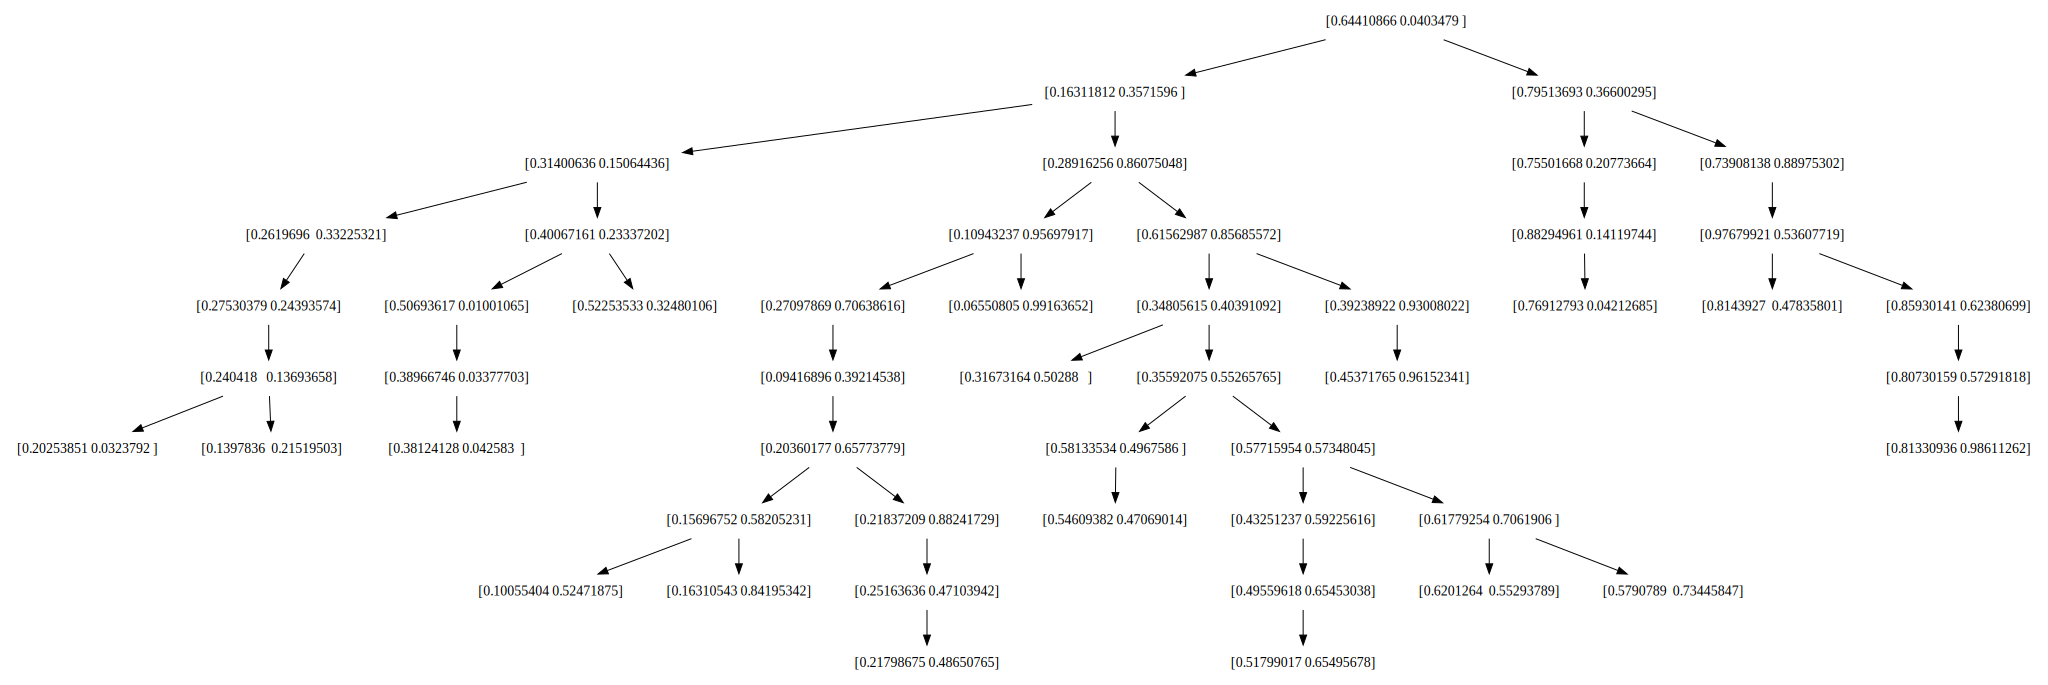

In [169]:
tree = KDTree(2)
n = 50
data = np.random.random(size = (50, 2))
for i in range(50):
    tree.insert(data[i, :])
tree.update_plot()
tree.plot


In [170]:
k_neighbors = tree.k_neighbors(np.array([0, 0]), 4)
k_neighbors = np.array([t[1].point for t in k_neighbors])
k_neighbors

[2.4009377572217256]
[2.4009377572217256, 6.486325123219456]
[2.4009377572217256, 6.486325123219456, 8.24445011648572]
[2.4009377572217256, 5.585959822339446, 8.24445011648572, 6.486325123219456]
passed max size, deleted last
[5.585959822339446, 6.486325123219456, 8.24445011648572, 7.391156493966329]
passed max size, deleted last
[6.486325123219456, 7.391156493966329, 8.24445011648572, 13.062940725470037]
passed max size, deleted last
[7.391156493966329, 13.062940725470037, 8.24445011648572, 23.769760889266188]
passed max size, deleted last
[8.24445011648572, 13.062940725470037, 15.186408505651396, 23.769760889266188]
passed max size, deleted last
[8.24445011648572, 13.062940725470037, 15.186408505651396, 23.769760889266188]
passed max size, deleted last
[8.24445011648572, 13.062940725470037, 15.186408505651396, 23.769760889266188]
passed max size, deleted last
[8.24445011648572, 13.062940725470037, 15.186408505651396, 23.769760889266188]
passed max size, deleted last
[8.24445011648572

array([[0.31400636, 0.15064436],
       [0.240418  , 0.13693658],
       [0.1397836 , 0.21519503],
       [0.20253851, 0.0323792 ]])

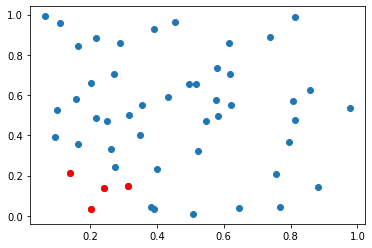

In [171]:
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(k_neighbors[:, 0], k_neighbors[:, 1], c = 'red')